<a href="https://colab.research.google.com/github/Ryan-Shaik/search/blob/index.edit/PyTorch_Fashion_MNIST_With_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import PIL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        # Note these are executed in the order they are called here
        # Some of these returns a color image, so need to convert the images
        transforms.RandomAffine(degrees = 10, translate = (0.05, 0.05), shear = 5),
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation=PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}

### Get Dataloader

In [ ]:
trainset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = True,
    download = True,
    transform = data_transforms["train"]
)

testset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = False,
    download = True,
    transform = data_transforms["test"]

)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = 32,
    shuffle = False,
    num_workers = 2

)

100%|██████████| 26421880/26421880 [00:02<00:00, 10671631.90it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 218548.59it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 698397.43it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15783828.21it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Adding BatchNorm using 32 as the input since 32 was the output of conv1
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64,3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropout(x)
        x = self.dropout(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.pool(x)
        x = x.view(-1,64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Adding L2 Regularisation

In [ ]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.001)

In [ ]:
epoch_log = []
loss_log = []
accuracy_log = []
epochs = 15

for epoch in range(epochs):
    print(f"Starting Epoch: {epoch + 1}")

    running_loss = 0.0

    # iterate through trainloader
    # Each cycle is a mini batch
    for i, data in enumerate(trainloader,0):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        net.train()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 90: # Show loss after every 50-mini-batches
            correct = 0 # Initializing variable to hold the count for the correct predictions
            total = 0 # Initializing variable to hold the count of the number of labels iterated


            net.eval()
            # we dont need gradient for validation so wrap in
            # inference_mode to save memory
            with torch.inference_mode():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)

                    # Forward propagate test batch through out model
                    outputs = net(images)

                    # Get predictions from the max value
                    _, predicted = torch.max(outputs.data, 1)

                    # Keep adding the label size to the total variable
                    total += labels.size(0)
                    # Keep running a total number of prediction predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct/total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f"Epoch: {epoch_num}, Mini-Batches Completed {(i + 1)}, Loss: {actual_loss:.3f}, Test_accuracy: {accuracy:.3f}")
                running_loss = 0.0

    # Store training stats after each epochs
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)



Starting Epoch: 1
Epoch: 1, Mini-Batches Completed 91, Loss: 2.254, Test_accuracy: 69.860
Epoch: 1, Mini-Batches Completed 191, Loss: 1.583, Test_accuracy: 73.670
Epoch: 1, Mini-Batches Completed 291, Loss: 1.426, Test_accuracy: 75.200
Epoch: 1, Mini-Batches Completed 391, Loss: 1.471, Test_accuracy: 76.690
Epoch: 1, Mini-Batches Completed 491, Loss: 1.429, Test_accuracy: 76.820
Epoch: 1, Mini-Batches Completed 591, Loss: 1.329, Test_accuracy: 78.560
Epoch: 1, Mini-Batches Completed 691, Loss: 1.250, Test_accuracy: 78.550
Epoch: 1, Mini-Batches Completed 791, Loss: 1.266, Test_accuracy: 79.090
Epoch: 1, Mini-Batches Completed 891, Loss: 1.266, Test_accuracy: 79.080
Epoch: 1, Mini-Batches Completed 991, Loss: 1.213, Test_accuracy: 78.940
Epoch: 1, Mini-Batches Completed 1091, Loss: 1.227, Test_accuracy: 81.000
Epoch: 1, Mini-Batches Completed 1191, Loss: 1.106, Test_accuracy: 81.010
Epoch: 1, Mini-Batches Completed 1291, Loss: 1.174, Test_accuracy: 81.560
Epoch: 1, Mini-Batches Complete

### Model Accuracy

In [ ]:
correct = 0
total = 0
with torch.inference_mode():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy =  100 * correct/total
print(f"Accuracy of model after training : {accuracy:.2f}%")

Accuracy of model after training : 89.39%


### Training PLot

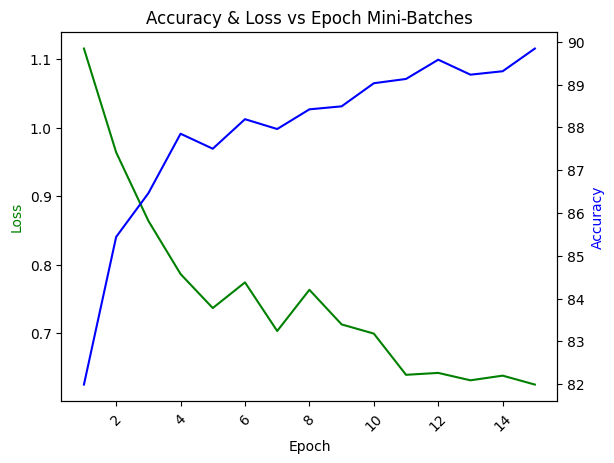

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, "g-", label = "Loss")
ax2.plot(epoch_log, accuracy_log, "b-", label = "Accuracy")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color = "g")
ax2.set_ylabel("Accuracy", color = "b")
plt.show();

In [ ]:
PATH = "./fashion_net.pth"
torch.save(net.state_dict(), PATH)